**IMPORT STATEMENTS**

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Input, GRU, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import cv2
import pathlib
import glob
import shutil
import random
import sys
import string
import seaborn as sns
from keras.callbacks import EarlyStopping
from tensorflow.python.keras.layers import Layer
from tensorflow.python.keras import backend as K
from matplotlib.font_manager import FontProperties
from seaborn import heatmap

In [2]:
#--------------------------------caution: terminal commands ---------------------------------------------
%cd
%cd .keras/datasets/
!rm -r *

/root
/root/.keras/datasets


In [3]:
########################################### download data from given url ###############################################

dataset_url = "https://storage.googleapis.com/gresearch/dakshina/dakshina_dataset_v1.0.tar"
data_dir = tf.keras.utils.get_file('dakshina_dataset_v1.0', origin=dataset_url, untar=True)

2008342528/2008340480 [==============================] - 19s 0us/step


In [4]:
#----------------------------------terminal command -----------------------------------------------
%cd /root/.keras/datasets/dakshina_dataset_v1.0/hi/lexicons/
!ls

/root/.keras/datasets/dakshina_dataset_v1.0/hi/lexicons
hi.translit.sampled.dev.tsv   hi.translit.sampled.train.tsv
hi.translit.sampled.test.tsv


In [5]:
train_data_path = "hi.translit.sampled.train.tsv"
test_data_path = "hi.translit.sampled.test.tsv"
validation_data_path = "hi.translit.sampled.dev.tsv"

**UTILITY FUNCTION FOR DATA PRE-PROCESSING**

In [6]:
################################################ preparing the data in required format #################################################

def data(path,input_token_index,target_token_index):
  input_texts = []
  target_texts = []
  with open(path, "r", encoding="utf-8") as f:
      lines = f.read().split("\n")
  del lines[-1]
  for line in lines:
      target_text, input_text, _ = line.split("\t")

      input_text = "\t"+input_text + "\n"
      target_text = "\t"+target_text + "\n"

      input_texts.append(input_text)
      target_texts.append(target_text)

  encoder_input_data = np.zeros( (len(input_texts), max_encoder_seq_length), dtype="int32")
  decoder_input_data = np.zeros( (len(input_texts), max_decoder_seq_length), dtype="int32")
  decoder_target_data = np.zeros((len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="int32")

  for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
      for t, char in enumerate(input_text):
          encoder_input_data[i, t] = input_token_index[char]
      encoder_input_data[i, t + 1 :] = input_token_index[" "]
      for t, char in enumerate(target_text):
          # decoder_target_data is ahead of decoder_input_data by one timestep
          decoder_input_data[i, t] = target_token_index[char]
          if t > 0:
              # decoder_target_data will be ahead by one timestep
              # and will not include the start character.
              decoder_target_data[i, t - 1, target_token_index[char]] = 1.0
      decoder_input_data[i, t + 1 :] = target_token_index[" "]
      decoder_target_data[i, t:, target_token_index[" "]] = 1.0
    
  return (encoder_input_data, decoder_input_data, decoder_target_data, target_texts, input_texts)

**PREPROCESSING THE DATA**

In [7]:
################################################ preprocessing the train data and getting dictionaries #################################################

input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
with open(train_data_path, "r", encoding="utf-8") as f:
    lines = f.read().split("\n")

del lines[-1]
for line in lines:
    target_text, input_text, _ = line.split("\t")
    input_text = "\t"+input_text + "\n"
    target_text = "\t"+target_text + "\n"

    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

input_characters.add(" ")
target_characters.add(" ")

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print("Number of samples:", len(input_texts))
print("Number of unique input tokens:", num_encoder_tokens)
print("Number of unique output tokens:", num_decoder_tokens)
print("Max sequence length for inputs:", max_encoder_seq_length)
print("Max sequence length for outputs:", max_decoder_seq_length)

input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])


Number of samples: 44204
Number of unique input tokens: 29
Number of unique output tokens: 66
Max sequence length for inputs: 22
Max sequence length for outputs: 21


**CUSTOM ATTENTION LAYER**

In [8]:
class AttentionLayer(Layer):

    ############################################# constructor for class AttentionLayer ##########################################
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    #########################################  Function to build ########################################################
    def build(self, input_shape):
        assert isinstance(input_shape, list)

        #-------------------------------------- Create a trainable weight variable for this layer-------------------------------------- 

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape) 


    #######################################  Function to call #################################
    def call(self, inputs, verbose=False):

        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs
        if verbose:
            print('encoder_out_seq>', encoder_out_seq.shape)
            print('decoder_out_seq>', decoder_out_seq.shape)

        ##############################  Function for Energy Step ##############################
        def energy_step(inputs, states):

            assert_msg = "States must be an iterable. Got {} of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            #------------------Some parameters required for shaping tensors----------------
            en_seq_len, en_hidden = encoder_out_seq.shape[1], encoder_out_seq.shape[2]
            de_hidden = inputs.shape[-1]

            #------------------Computing S.Wa where S=[s0, s1, ..., si]--------------------
            W_a_dot_s = K.dot(encoder_out_seq, self.W_a)

            #------------------Computing hj.Ua---------------------------------------------
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)
            if verbose:
                print('Ua.h>', U_a_dot_h.shape)

            #------------------Computing tanh(S.Wa + hj.Ua)--------------------------------
            Ws_plus_Uh = K.tanh(W_a_dot_s + U_a_dot_h)
            if verbose:
                print('Ws+Uh>', Ws_plus_Uh.shape)

            #------------------Computing softmax(va.tanh(S.Wa + hj.Ua))-------------------------------
            e_i = K.squeeze(K.dot(Ws_plus_Uh, self.V_a), axis=-1)
            e_i = K.softmax(e_i)

            if verbose:
                print('ei>', e_i.shape)

            return e_i, [e_i]

        ####################### Step function for computing ci using ei ###############################
        def context_step(inputs, states):            

            assert_msg = "States must be an iterable. Got {} of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            c_i = K.sum(encoder_out_seq * K.expand_dims(inputs, -1), axis=1)
            if verbose:
                print('ci>', c_i.shape)
            return c_i, [c_i]

        fake_state_c = K.sum(encoder_out_seq, axis=1)
        fake_state_e = K.sum(encoder_out_seq, axis=2)  

        #-----------------------Computing energy outputs -----------------------------------------------
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e],
        )

        #-----------------------Computing context vectors ----------------------------------------------
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c],
        )

        return c_outputs, e_outputs

    ############################ Outputs produced by the layer ##########################################
    def compute_output_shape(self, input_shape):        
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]


**MACHINE TRANSLITERATOR**


In [9]:

class Machine_Transliterator():

  ############################################# constructor for class Machine_Transliterator ##########################################

  def __init__(self,max_encoder_seq_length,max_decoder_seq_length,encoder_embed_size, decoder_embed_size,
               num_encoder_layers,num_decoder_layers,epochs, hidden_layer_size,
               num_encoder_tokens, cell_type, num_decoder_tokens,input_token_index, target_token_index, 
               activation="softmax",optimizer="rmsprop",dropout=0.05):
    
    self.cell_type= cell_type
    self.hidden_layer_size = hidden_layer_size  
    self.optimizer = optimizer
    self.activation = activation   
    self.dropout=dropout

    #-------------------------------------- Number of hidden layers -------------------------------------

    self.num_encoder_layers = num_encoder_layers
    self.num_decoder_layers=num_decoder_layers

    #-------------------------------------- sequence length -------------------------------------
    self.max_decoder_seq_length=max_decoder_seq_length
    self.max_encoder_seq_length=max_encoder_seq_length

    #---------------------------------------------Embedding size-------------------------------------
    self.encoder_embed_size = encoder_embed_size
    self.decoder_embed_size = decoder_embed_size
    
    #-----------------information obtained after preprocessing of data-------------------------------------
    self.num_encoder_tokens = num_encoder_tokens
    self.num_decoder_tokens = num_decoder_tokens

    #-----------------------------dictionaries----------------------------------------------------
    self.input_token_index = input_token_index
    self.target_token_index = target_token_index

 


#########################################function to build model ###########################################

  def build_model(self):
    
    encoder_inputs = keras.Input(shape=(None,))  
    encoder_embedding_output = tf.keras.layers.Embedding(input_dim = self.num_encoder_tokens, output_dim = self.encoder_embed_size, name = "encoder_embedding_layer")(encoder_inputs)

#------------------------------ if cell type = LSTM -------------------------------------------------------------
    if self.cell_type == "lstm":
     #--------------------- encoder -----------------------------------
      encoder = keras.layers.LSTM(self.hidden_layer_size, return_state=True,return_sequences=True,dropout=self.dropout,use_bias=True, name = "encoder_layer_0")
      encoder_outputs, state_h, state_c = encoder(encoder_embedding_output)
      encoder_states = [state_h, state_c]

      #---------------------------decoder ---------------------------------------------------
      decoder_inputs = keras.Input(shape=(None, )) 
      decoder_embedding_output = tf.keras.layers.Embedding(input_dim = self.num_decoder_tokens, output_dim = self.decoder_embed_size, name = "decoder_embedding_layer")(decoder_inputs)

      decoder = keras.layers.LSTM(self.hidden_layer_size, return_sequences=True, return_state=True,dropout=self.dropout,use_bias=True, name = "decoder_layer_0")
      decoder_outputs, _, _= decoder(decoder_embedding_output, initial_state = encoder_states)

      attn_layer = AttentionLayer(name='attention_layer')
      attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])
      decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

      


#------------------------------ if cell type = Simple RNN -------------------------------------------------------------
    elif self.cell_type == "rnn":
      #--------------------- encoder -----------------------------------
      encoder_inputs = keras.Input(shape=(self.max_encoder_seq_length,))
      encoder_embedding_output = tf.keras.layers.Embedding(input_dim = self.num_encoder_tokens, output_dim = self.encoder_embed_size, name = "encoder_embedding_layer", input_length=self.max_encoder_seq_length)(encoder_inputs)

      encoder = keras.layers.SimpleRNN(self.hidden_layer_size, return_state=True,return_sequences=True,dropout=self.dropout, use_bias=True, name = "encoder_layer_0", unroll=True)
      encoder_outputs, state = encoder(encoder_embedding_output)
      encoder_states = [state]

      #---------------------------decoder ---------------------------------------------------
      decoder_inputs = keras.Input(shape=(self.max_decoder_seq_length, ))
      decoder_embedding_output = tf.keras.layers.Embedding(input_dim = self.num_decoder_tokens, output_dim = self.decoder_embed_size, name = "decoder_embedding_layer", input_length=self.max_decoder_seq_length)(decoder_inputs)

      decoder = keras.layers.SimpleRNN(self.hidden_layer_size, return_state=True,return_sequences=True, dropout=self.dropout, use_bias=True, name = "decoder_layer_0", unroll=True)
      decoder_outputs, _ = decoder(decoder_embedding_output, initial_state = encoder_states)

      attn_layer = AttentionLayer(name='attention_layer')
      attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])
      decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])



#------------------------------ if cell type = GRU -------------------------------------------------------------
    elif self.cell_type == "gru":
      #--------------------- encoder -----------------------------------
      encoder = keras.layers.GRU(self.hidden_layer_size, return_state=True,return_sequences=True,dropout=self.dropout,use_bias=True, name = "encoder_layer_0")
      encoder_outputs, state = encoder(encoder_embedding_output)
      encoder_states = [state]

      #---------------------------decoder ---------------------------------------------------
      decoder_inputs = keras.Input(shape=(None, ))      
      decoder_embedding_output = tf.keras.layers.Embedding(input_dim = self.num_decoder_tokens, output_dim = self.decoder_embed_size, name = "decoder_embedding_layer")(decoder_inputs)
      
      decoder = keras.layers.GRU(self.hidden_layer_size, return_state=True,return_sequences=True, dropout=self.dropout,use_bias=True, name = "decoder_layer_0")
      decoder_outputs, _ = decoder(decoder_embedding_output, initial_state = encoder_states)

      attn_layer = AttentionLayer(name='attention_layer')
      attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])
      decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

    decoder_dense = keras.layers.Dense(self.num_decoder_tokens, activation = self.activation,use_bias=True, name = "dense")
    dense_time = TimeDistributed(decoder_dense, name='time_distributed_layer')
    decoder_pred = dense_time(decoder_concat_input)

    model = keras.Model([encoder_inputs, decoder_inputs], decoder_pred)
    
    #-----------------compile the model -------------------------------------
    model.compile(
         optimizer=self.optimizer,
         loss="categorical_crossentropy",
         metrics=["accuracy"]
         ) 

#-------------------------- return final model ---------------------------------------------------------
    return model

#########################################function for training the model ###########################################

  def train_model(self,encoder_input_data,decoder_input_data,decoder_target_data,epochs,batch_size,
                  val_encoder_input_data, val_decoder_input_data, val_decoder_target_data):
    
     model=self.build_model()
  
     model.fit(
        [encoder_input_data, decoder_input_data],
        decoder_target_data,
        batch_size = batch_size,
        epochs = epochs,
        validation_data = ([val_encoder_input_data, val_decoder_input_data],val_decoder_target_data),
        # callbacks=[WandbCallback(), EarlyStopping(patience = 5)]
        callbacks=[EarlyStopping(patience = 5)]
        )
     return model

######################################### function for inference on the model ###########################################
  
  def sampling_inference(self, model, num_encoder_layers, num_decoder_layers):

    encoder_model = None
    decoder_model = None
    if self.cell_type == "lstm":

      #-----------------ENCODER----------------------------
      e_inputs = model.input[0]
      e_embed_layer = model.get_layer("encoder_embedding_layer")
      encoder_inputs = e_embed_layer(e_inputs)

      encoder_cell = model.get_layer("encoder_layer_" + str(num_encoder_layers-1))
      encoder_outputs, state_h_enc, state_c_enc = encoder_cell(encoder_inputs)
      encoder_states = [state_h_enc, state_c_enc]

      #----------------encoder model-------------------------------
      encoder_model = keras.Model(inputs = e_inputs, outputs = [encoder_outputs, state_h_enc, state_c_enc])

      #------------------DECODER------------------------------
      decoder_state_input_h = keras.Input(shape=(self.hidden_layer_size,), name="input_decoder_h")
      decoder_state_input_c = keras.Input(shape=(self.hidden_layer_size,), name="input_decoder_c")
      decoder_hidden_state_input = Input(shape=(22,self.hidden_layer_size))
      decoder_state_inputs = [decoder_state_input_h, decoder_state_input_c]

      d_inputs = model.input[1] #input_2
      d_embed_layer = model.get_layer("decoder_embedding_layer")
      decoder_inputs = d_embed_layer(d_inputs)

      #---------------decoder cell layers---------------------------
      decoder_cell = model.get_layer("decoder_layer_" + str(num_decoder_layers-1))
      decoder_outputs, state_h_dec, state_c_dec = decoder_cell(decoder_inputs, initial_state = decoder_state_inputs)
      decoder_states = [state_h_dec, state_c_dec]

      #-------------------------attention inference ------------------
      attn_layer = model.get_layer("attention_layer")
      attn_inf_out, attn_inf_states = attn_layer([decoder_hidden_state_input, decoder_outputs])

      #------------------------concatenation----------------------------
      concate = model.get_layer("concat_layer")
      decoder_inf_concat = concate([decoder_outputs, attn_inf_out])

      #-------A dense softmax layer to get generate probability over the target vocabulary --------------------
      time_dist_dense = model.get_layer("time_distributed_layer")
      decoder_inf_pred = time_dist_dense(decoder_inf_concat)


      decoder_model = keras.Model( 
                              [d_inputs] + [decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c],
                              [decoder_inf_pred] + [state_h_dec, state_c_dec] + [attn_inf_states]
                            )
    #-------------------------------------if cell type = Simple RNN or GRU---------------------------------------------
    elif self.cell_type =="rnn" or self.cell_type =="gru":

      #---------------------------ENCODER---------------------------------
      e_inputs = model.input[0]
      e_embed_layer = model.get_layer("encoder_embedding_layer")
      encoder_inputs = e_embed_layer(e_inputs)

      encoder_cell = model.get_layer("encoder_layer_" + str(num_encoder_layers-1))
      encoder_outputs, state_h_enc = encoder_cell(encoder_inputs)
      encoder_states = [state_h_enc]

      #----------------------encoder model-------------------------------
      encoder_model = keras.Model(inputs = e_inputs, outputs = [encoder_outputs, state_h_enc])

      #-------------------------DECODER---------------------------------------------
      decoder_state_input_h = keras.Input(shape=(self.hidden_layer_size,), name="input_decoder_h")
      decoder_hidden_state_input = Input(shape=(22,self.hidden_layer_size))
      decoder_state_inputs = [decoder_state_input_h]

      d_inputs = model.input[1] 
      d_embed_layer = model.get_layer("decoder_embedding_layer")
      decoder_inputs = d_embed_layer(d_inputs)

      #-------------------------decoder cell layers---------------------------------
      decoder_cell = model.get_layer("decoder_layer_" + str(num_decoder_layers-1))
      decoder_outputs, state_h_dec = decoder_cell(decoder_inputs, initial_state = decoder_state_inputs)
      decoder_states = [state_h_dec]

      #-----------------------------attention inference-----------------------------------
      attn_layer = model.get_layer("attention_layer")
      attn_inf_out, attn_inf_states = attn_layer([decoder_hidden_state_input, decoder_outputs])

      #------------------------------concatenation--------------------------------------
      concate = model.get_layer("concat_layer")
      decoder_inf_concat = concate([decoder_outputs, attn_inf_out])

      #----------- A dense softmax layer to get generate probability over the target vocabulary -----------
      time_dist_dense = model.get_layer("time_distributed_layer")
      decoder_inf_pred = time_dist_dense(decoder_inf_concat)


      decoder_model = keras.Model( 
                              [d_inputs] + [decoder_hidden_state_input, decoder_state_input_h],
                              [decoder_inf_pred] + [state_h_dec] + [attn_inf_states]
                            )
      #  decoder_model = Model(inputs=[encoder_inf_states, decoder_init_state, decoder_inf_inputs],
      #                     outputs=[decoder_inf_pred, attn_inf_states, decoder_inf_state])
      
    reverse_input_char_index = dict((i, char) for char, i in self.input_token_index.items())
    reverse_target_char_index = dict((i, char) for char, i in self.target_token_index.items())
    return (reverse_input_char_index,reverse_target_char_index, encoder_model, decoder_model)

##################################################function for decoding input sequence ###########################################

  def decode_sequence(self, input_data, encoder_model, decoder_model, max_encoder_seq_length, max_decoder_seq_length, target_token_index, reverse_input_char_index, reverse_target_char_index):


    # max_encoder_seq_length = input_data.shape[0]

    decoded_sentence = ""

    #---------------- Attention weights --------------------------------
    attention_weights = []

    # ------ -----------if cell type=LSTM ---------------------------------
    if self.cell_type =="lstm":
      e_out, e_h, e_c = encoder_model.predict(input_data)
      states = [e_h, e_c]      
      target_seq = np.zeros((1, 1),dtype="int32")
      target_seq[0, 0] = self.target_token_index["\t"]  

    # ------ -----------if cell type= Simple RNN or GRU --------------------
    elif self.cell_type == "rnn" or self.cell_type =="gru":
      e_out, e_h = encoder_model.predict(input_data)
      states_value = [e_h]
      target_seq = np.zeros((1, 1),dtype="int32")
      target_seq[0, 0] = self.target_token_index["\t"]  

    for i in range(max_decoder_seq_length):
      # ------------------if cell type=LSTM ---------------------------------
      if self.cell_type =="lstm":
        # print("entered decoder")
        output_tokens, h, c, atw = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        # print(i,"th atw shape : ", atw.shape)
        atw = atw.reshape(atw.shape[2],1)
        attention_weights.append(atw)
        e_h, e_c = h, c
      # ------------------if cell type= Simple RNN or GRU --------------------
      elif self.cell_type =="rnn" or self.cell_type =="gru":
        output_tokens, h, atw = decoder_model.predict([target_seq] + [e_out, e_h])
        atw = atw.reshape(atw.shape[2],1)
        attention_weights.append(atw)
        e_h = h

      target_seq[0,0] = np.argmax(output_tokens[0, -1, :])

      decoded_sentence += reverse_target_char_index[np.argmax(output_tokens[0, -1, :])]

  #--------------------------- return (attention weights, input seq, output seq) ------------------------------
    attention_weights = np.asarray(attention_weights)
    rows, cols, _ = attention_weights.shape
    attention_weights = attention_weights.reshape(rows,cols) 

    input_sentence = ""
    for i in range(max_encoder_seq_length):
      input_sentence += reverse_input_char_index[input_data[0][i]]
    
    return (attention_weights,input_sentence,decoded_sentence)
  
  ################################################## function for attention weights ###########################################

  def get_attention_weights(self,output_corpus, input_data, max_encoder_seq_length, reverse_input_char_index, reverse_target_char_index, encoder_model, decoder_model, num_examples = 10):   

    attentions = []
    inputs = []
    predicts = []
    #------------------------------ creating vectorised form of predicted output --------------------------------
    for i in range(num_examples):
      attention_weights,input_sentence,decoded_sentence = self.decode_sequence(input_data[i:i+1], encoder_model, decoder_model, max_encoder_seq_length, self.max_decoder_seq_length, target_token_index, reverse_input_char_index, reverse_target_char_index)
      attentions.append(attention_weights)
      inputs.append(input_sentence)
      predicts.append(decoded_sentence) 

    return (attentions,inputs,predicts)

#===================================== end of class Machine_Transliterator ==========================================



**PARAMETERS**

In [10]:
cell_type = "lstm"
batch_size = 64  # Batch size for training.
epochs = 30  # Number of epochs to train for.
hidden_layer_size= 256  # Latent dimensionality of the encoding space.
activation = "softmax"
optimizer = "Adam"
encoder_embed_size = 1024 #Encoder embedsize
decoder_embed_size = 27 #Decoder embedsize
num_encoder_layers= 1  # number of hidden layers in encoder
num_decoder_layers= 1    # number of hidden layers in decoder
dropout=0.1 #Dropout

**PREPROCESSING THE DATA**

In [ ]:
############################# preprocessing the data ################################

(encoder_input_data,decoder_input_data,decoder_target_data, _, _)=data(train_data_path,input_token_index,target_token_index)
(val_encoder_input_data,val_decoder_input_data,val_decoder_target_data, val_target_texts, val_input_texts)=data(validation_data_path ,input_token_index,target_token_index)

In [12]:

(t_encoder_input_data,t_decoder_input_data,t_decoder_target_data, t_target_texts, t_input_texts)=data(test_data_path ,input_token_index,target_token_index)

**CREATING MACHINE TRANSLITERATOR**

In [13]:
########################## creating machine transliterator object ###############################
machine = Machine_Transliterator(
      max_encoder_seq_length,max_decoder_seq_length,encoder_embed_size, 
      decoder_embed_size,num_encoder_layers,num_decoder_layers,
      batch_size, hidden_layer_size, num_encoder_tokens, cell_type, num_decoder_tokens, 
      input_token_index,target_token_index, activation, optimizer,dropout
      )

**TRAINING**

In [14]:
model = machine.train_model(
    encoder_input_data, decoder_input_data,decoder_target_data,epochs,batch_size,
    val_encoder_input_data, val_decoder_input_data, val_decoder_target_data
    )

Epoch 1/30
691/691 [==============================] - 80s 65ms/step - loss: 1.0648 - accuracy: 0.7450 - val_loss: 0.2524 - val_accuracy: 0.9220
Epoch 2/30
691/691 [==============================] - 42s 61ms/step - loss: 0.2357 - accuracy: 0.9260 - val_loss: 0.1830 - val_accuracy: 0.9413
Epoch 3/30
691/691 [==============================] - 43s 62ms/step - loss: 0.1761 - accuracy: 0.9433 - val_loss: 0.1619 - val_accuracy: 0.9473
Epoch 4/30
691/691 [==============================] - 42s 61ms/step - loss: 0.1531 - accuracy: 0.9503 - val_loss: 0.1500 - val_accuracy: 0.9519
Epoch 5/30
691/691 [==============================] - 42s 61ms/step - loss: 0.1361 - accuracy: 0.9555 - val_loss: 0.1458 - val_accuracy: 0.9521
Epoch 6/30
691/691 [==============================] - 43s 62ms/step - loss: 0.1264 - accuracy: 0.9587 - val_loss: 0.1417 - val_accuracy: 0.9542
Epoch 7/30
691/691 [==============================] - 42s 61ms/step - loss: 0.1142 - accuracy: 0.9629 - val_loss: 0.1376 - val_accuracy:

In [15]:
# tf.keras.utils.plot_model(model,to_file='model.png',show_shapes=True)

**INFERENCE**

In [16]:
(reverse_input_char_index,reverse_target_char_index, encoder_model, decoder_model) = machine.sampling_inference(model, num_encoder_layers, num_decoder_layers)

**TESTING ACCURACY**

In [17]:
########################### validation accuracy calculation ###############################
input_data = t_encoder_input_data #english vectors
output_corpus = t_target_texts #hindi words
num_examples = 10

attentions, inputs, predicts = machine.get_attention_weights(output_corpus, input_data, max_encoder_seq_length, reverse_input_char_index, reverse_target_char_index, encoder_model, decoder_model, num_examples)


**REPRESENTING RESULTS ON TEST DATA**

**PREPARING HEATMAP**

In [18]:
#--------------------------------caution: terminal commands ---------------------------------------------
%cd
%cd ../content
!rm grid.*
!rm Nirmala.ttf
!rm nirmala.png             
!rm sharefonts.net.txt 

/root
/content
rm: cannot remove 'grid.*': No such file or directory


In [19]:
################################### Downloading hindi font ###########################################

#--------------------------------caution: terminal commands ------------------------------------------
!wget https://www.wfonts.com/download/data/2016/04/29/nirmala-ui/nirmala-ui.zip
!unzip nirmala-ui.zip

--2021-05-21 09:02:39--  https://www.wfonts.com/download/data/2016/04/29/nirmala-ui/nirmala-ui.zip
Resolving www.wfonts.com (www.wfonts.com)... 104.225.219.210
Connecting to www.wfonts.com (www.wfonts.com)|104.225.219.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 686493 (670K) [application/octetstream]
Saving to: ‘nirmala-ui.zip.3’

nirmala-ui.zip.3    100%[===================>] 670.40K   555KB/s    in 1.2s    

2021-05-21 09:02:40 (555 KB/s) - ‘nirmala-ui.zip.3’ saved [686493/686493]

Archive:  nirmala-ui.zip
  inflating: nirmala.png             
  inflating: Nirmala.ttf             
  inflating: sharefonts.net.txt      


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


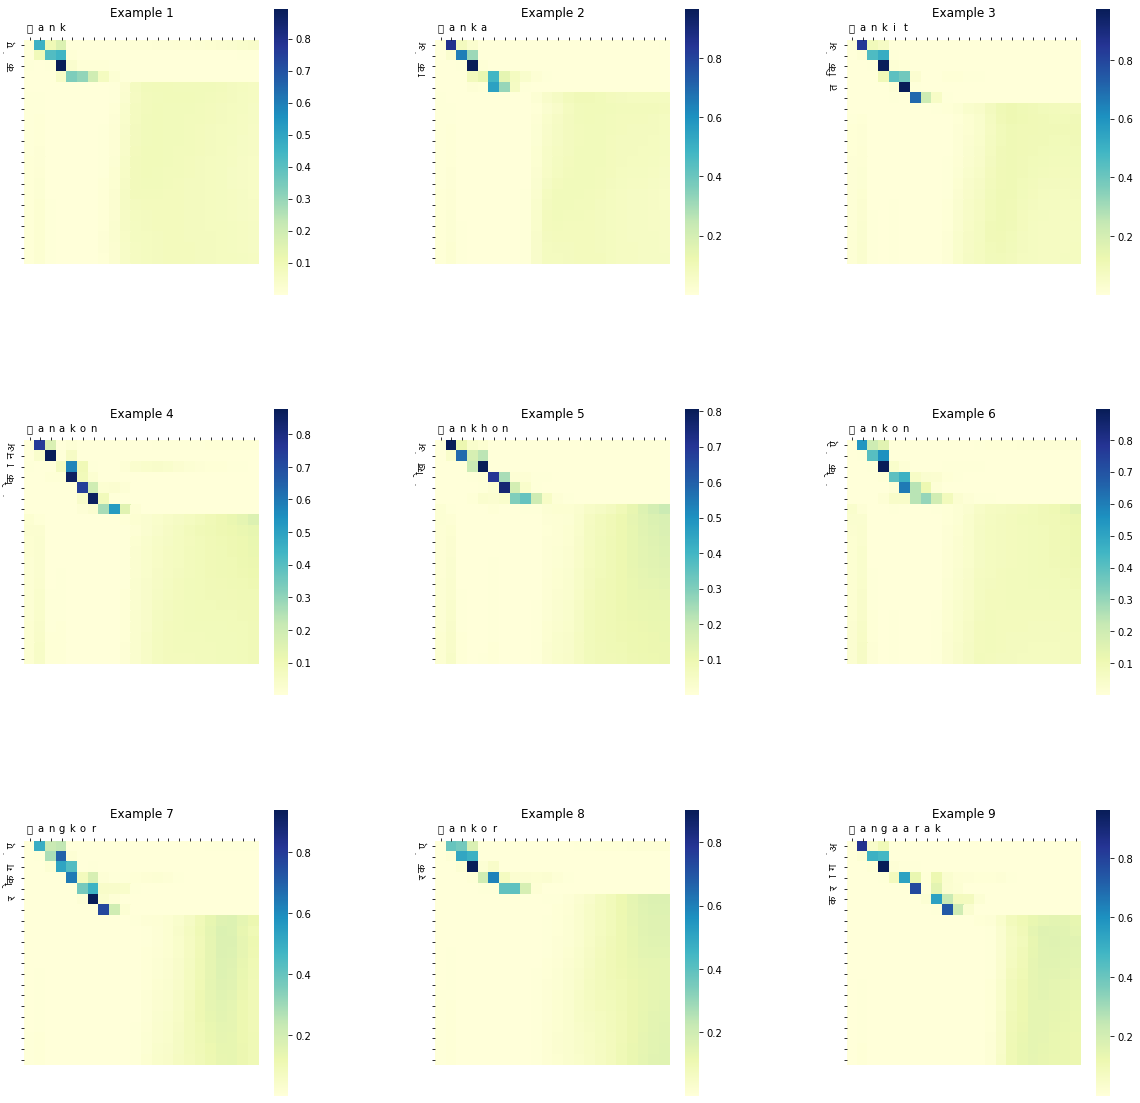

In [20]:
#-------------------------------- Displaying heatmaps grid ---------------------------------------------
fig , axn = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(20, 20))

hindi_font = FontProperties(fname = 'Nirmala.ttf')

for i in range(9):
  ax = plt.subplot(3, 3, i+1)
  xticks = [*inputs[i]]
  yticks = [*predicts[i]]
  ax.set_yticklabels(yticks, fontproperties=hindi_font)
  ax.xaxis.set_ticks_position('top')  
  h = heatmap( attentions[i], annot=False, cmap='YlGnBu', xticklabels=xticks, yticklabels=yticks, ax = ax, annot_kws={'fontproperties':hindi_font})
  ax.set_title('Example '+str(i+1))
  ax.set_aspect('equal')

plt.subplots_adjust(wspace = 0.4, hspace = 0.4)